In [79]:
from scipy.optimize import minimize, NonlinearConstraint
import numpy as np 
import matplotlib.pyplot as plt


In [80]:
import numpy as np
from itertools import permutations

def permanent(matrix):
    n = len(matrix)
    perm_sum = 0

    for perm in permutations(range(n)):
        product = 1
        for i in range(n):
            product *= matrix[i, perm[i]]
        perm_sum += product

    return perm_sum

In [81]:
def idxs_delete(bitstring):

    idx_to_delete = []
    for i,bit in enumerate(bitstring):
        if int(bit) == 0:
            idx_to_delete.append(i)
            
    return np.array(idx_to_delete)

In [82]:
def drop_columns_and_rows(matrix, input_state):
    
    # Convert binary string to a list of integers
    indices_to_drop = idxs_delete(input_state)

    # Drop the specified columns and rows
    if indices_to_drop.size == 0:
        return matrix
    else:
        new_matrix = np.delete(matrix, indices_to_drop, axis=0)
        new_matrix = np.delete(new_matrix, indices_to_drop, axis=1)
        return new_matrix

In [83]:
def generate_input_states(inp_length):
    try:
        input_states = [format(i, f'0{inp_length}b') for i in range(2**inp_length)]
    except:
        input_states = []
        print('Error')
        
    return input_states

In [84]:
def return_permanents(matrix):
    
    input_states = generate_input_states(int(len(matrix)/2))
    perm_list = []
    
    for inp_state in input_states:
        perm_list.append(permanent(drop_columns_and_rows(matrix, inp_state)))
        
    return np.array(perm_list)

In [85]:
N = 4 #number of modes in the system
A_target = np.array([1, 1, 1, -1]) #target output of CCZ
print(A_target)

[ 1  1  1 -1]


In [86]:
#cost function
def cost_fun_F(U_vector): 
    #reshape to matrix
    U = U_vector.reshape(N,N)
    U = U/ np.linalg.norm(U,2) 
    A_vect = return_permanents(U) #matrix with the permanents
    
    F = ((np.dot(A_target, A_vect))**2)/((N/2)**2*np.linalg.norm(A_vect)**2)
    
    return -1*(F)

In [87]:
#constraint (unused for now)
def constraint_norm1(x):
    return np.linalg.norm(x,2) - 1

constraint = {'type': 'eq', 'fun': constraint_norm1}
nonlinear_constraint = NonlinearConstraint(constraint_norm1, 0, 0)

In [88]:
#minimization test
U_init = np.random.rand(N,N)
U_init = U_init.flatten()
minimum = minimize(cost_fun_F, U_init, method='BFGS', tol=1e-4)#, constraints=[constraint])
print(minimum)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.999999999920039
        x: [-1.460e-01 -3.578e+00 ...  9.426e-01  1.251e+00]
      nit: 11
      jac: [ 7.078e-07 -1.185e-06 ...  3.137e-06 -2.265e-06]
 hess_inv: [[ 1.154e+00  7.765e-01 ...  2.675e-02 -2.958e-02]
            [ 7.765e-01  1.031e+01 ... -5.792e-01 -1.150e+00]
            ...
            [ 2.675e-02 -5.792e-01 ...  9.826e-01  1.737e-02]
            [-2.958e-02 -1.150e+00 ...  1.737e-02  1.033e+00]]
     nfev: 204
     njev: 12


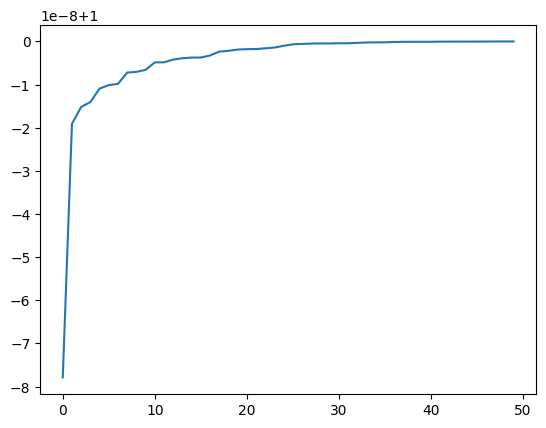

[0.99999992 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [89]:
cost = []
U_matrices = []

for i in range(50):
    U_init = np.random.rand(N,N)
    U_init = U_init.flatten() #needs to be flattened for minimization
    #minimization
    minimum = minimize(cost_fun_F, U_init, method='BFGS', tol=1e-4)#, constraints=[nonlinear_constraint])
    cost.append(-1*minimum.fun)
    U_matrices.append(minimum.x)
 
cost = np.array(cost)
U_matrices = np.array(U_matrices)    
sorted_indices = np.argsort(cost)
cost = cost[sorted_indices]
U_matrices = U_matrices[sorted_indices]
    
plt.plot(cost)
plt.show()

print(cost)

In [151]:
#cost function
def cost_fun(U_vector): 
    #reshape to matrix
    U = U_vector.reshape(N,N)
    U_target = U/ np.linalg.norm(U,2) 
    A_vect = return_permanents(U_target)

    F = ((np.dot(A_target, A_vect))**2)/((N/2)**2*np.linalg.norm(A_vect)**2)
    
    S = A_vect[0]**2#/(np.linalg.norm(U,2)**(2*N))            #success probability
    
    return -1*(59000*F + S )

In [152]:

U_init = U_matrices[-1].flatten()
minimum = minimize(cost_fun, U_init, method='BFGS', tol=1e-4)#, constraints=[nonlinear_constraint])
cost_final = -1*minimum.fun
U_matrix_final = minimum.x
print(U_matrix_final)
print(cost_final)

[ 0.32066031 -0.39151576  1.7335041   0.20034974 -1.84792475  0.22166405
  0.99143238 -0.19965181  0.97069407  1.74150166  0.82841302 -0.02967012
 -0.43303835  0.49948776 -0.24142329  2.16188339]
59000.1174931761


In [153]:
#cost function
def cost_fun_S(U_vector): 
    #reshape to matrix
    U = U_vector.reshape(N,N)
    U = U/ np.linalg.norm(U,2) 
    A_vect = return_permanents(U)
    A_tar_vect = A_target.flatten()
    #print("permanent matrix: ", A_vect)
    #F = np.abs(np.dot(A_tar_vect, A_vect))/((N/2)**2*(max(A_vect)))
    
    F = ((np.dot(A_tar_vect, A_vect))**2)/((N/2)**2*np.linalg.norm(A_vect)**2)
    #F = 1 - np.linalig.norm((A_tar_vect - A_vect))
    #print(F)
    S = A_vect[0]**2            #success probability
    
    return -1*(S )

In [154]:
print("Success probability: ",-1*cost_fun_S(U_matrix_final))
print("Fidelity: ",-1*cost_fun_F(U_matrix_final))

Success probability:  0.11752493880709587
Fidelity:  0.999999999461649
